Explore logistic regression classification of 5,8 digits   
2017-11-27 Jeff Fessler, University of Michigan  
STUDENT TEMPLATE VERSION

In [54]:
using Plots
using PyPlot
pyplot();

In [2]:
# read the MNIST data file for digits 5 and 8
# download from web if needed
file0 = "data5"
file1 = "data8"
if !isfile(file0)
    download("http://cis.jhu.edu/~sachin/digit/$file0", file0)
end
if !isfile(file1)
    download("http://cis.jhu.edu/~sachin/digit/$file1", file1)
end

nx = 28 # original image size
ny = 28
nrep = 1000

fp = open(file0, "r")
x0 = read(fp, UInt8, (nx,ny,nrep))
close(fp)

fp = open(file1, "r")
x1 = read(fp, UInt8, (nx,ny,nrep))
close(fp)

iy = 2:ny
x0 = x0[:,iy,:] # make images non-square to help debug
x1 = x1[:,iy,:]
ny = length(iy)

@show size(x0);
@show size(x1);

size(x0) = (28, 27, 1000)
size(x1) = (28, 27, 1000)


In [3]:
# function to display a 2d image
jim = (x; mx=size(x,1), my=size(x,2)) ->
    heatmap(1:size(x,1), 1:size(x,2), x,
        xtick=[1,mx], ytick=[1,my], yflip=true,
        color=:grays, transpose=true, aspect_ratio=1)
# function to display mosaic of multiple images
imshow3 = (x) -> begin
    tmp = permutedims(x, [1, 3, 2])
    tmp = reshape(tmp, :, ny)
    jim(tmp, mx=nx, my=ny)
end;


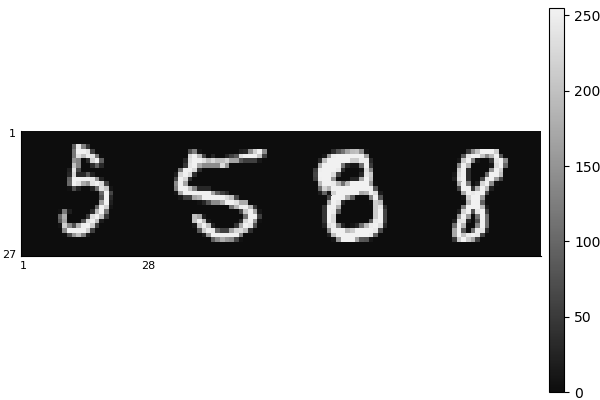

In [4]:
# look at a couple of the images
imshow3(cat(3, x0[:,:,44:45], x1[:,:,654:655]))

In [5]:
# use some data for training, and some for test
ntrain = 100
ntest = nrep - ntrain
train0 = x0[:,:,1:ntrain] # training data
train1 = x1[:,:,1:ntrain]
test0 = x0[:,:,(ntrain+1):end] # testing data
test1 = x1[:,:,(ntrain+1):end];


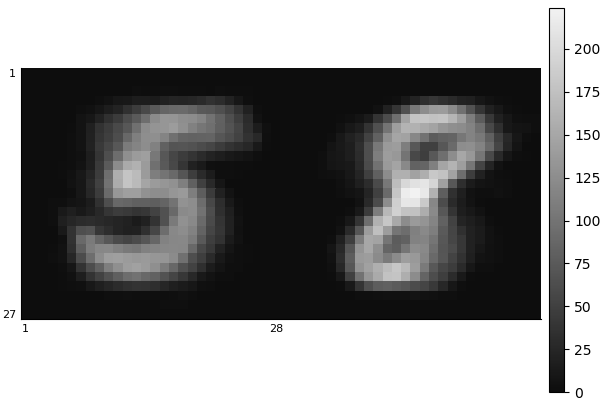

In [6]:
# look at mean image from each class just to get a sense of things

#mean0 = mean(train0, 3) # makes a 3D array 28x28x1
#mean1 = mean(train1, 3)
mean0 = squeeze(mean(train0, 3), 3)
mean1 = squeeze(mean(train1, 3), 3)

imshow3(cat(3, mean0, mean1))


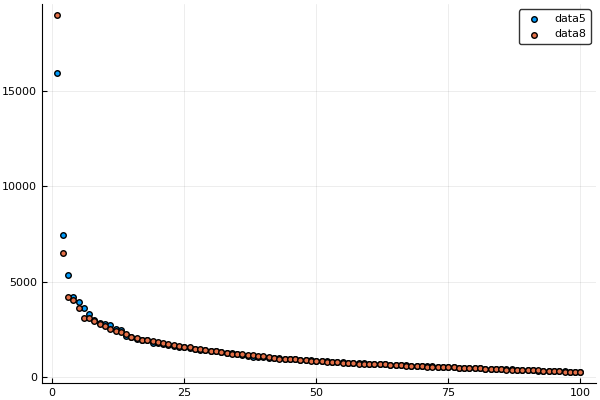

In [7]:
# Use training data to estimate the subspaces
u0, s0, ~ = svd(reshape(train0, nx*ny, :))
u1, s1, ~ = svd(reshape(train1, nx*ny, :))

# Examine the scree plots to choose a rank!
plot(1:ntrain, s0, line=(:dots, :blue), label="$file0")
plot!(1:ntrain, s1, line=(:dots,:red), label="$file1")

In [8]:
# Estimate subspaces for each digit class from training data
r0 = 3
r1 = 3
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r0], nx, ny, :);


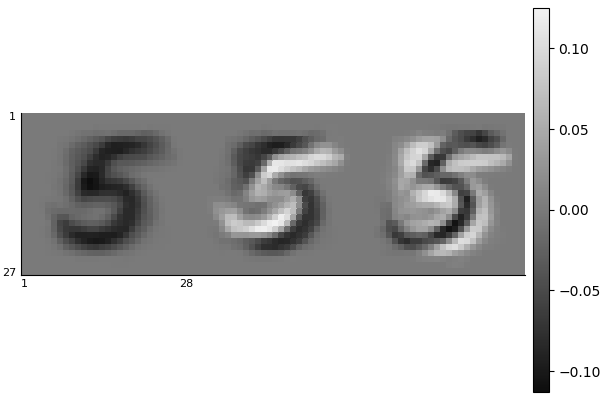

In [9]:
# show images of the 1st 3 components of first digit subspace
imshow3(q0[:,:,1:3])


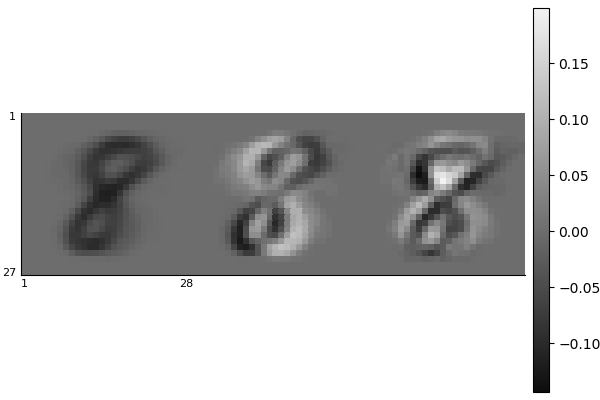

In [10]:
# show images of the 1st 3 components of second digit subspace
imshow3(q1[:,:,1:3])

In [11]:
# Classify all the test data based on your subspace estimates
# and count number of misclassified digits
# reshape() and vecnorm() and mapslices() probably useful here

Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)

y0 = reshape(test0, nx*ny, :)
y00 = y0 - Q0*(Q0'*y0)
y01 = y0 - Q1*(Q1'*y0)
correct0 = mapslices(vecnorm, y00, 1) .< mapslices(vecnorm, y01, 1)
@show sum(correct0) / ntest;

y1 = reshape(test1, nx*ny, :)
y10 = y1 - Q0*(Q0'*y1)
y11 = y1 - Q1*(Q1'*y1)
correct1 = mapslices(vecnorm, y10, 1) .> mapslices(vecnorm, y11, 1)
@show sum(correct1) / ntest;

sum(correct0) / ntest = 0.9111111111111111
sum(correct1) / ntest = 0.8744444444444445



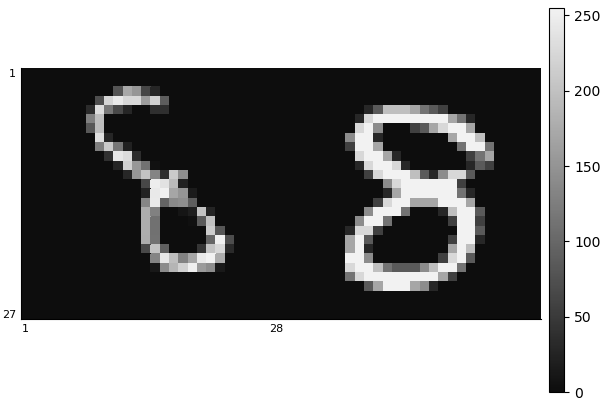

In [12]:
# show some bad cases
bad1 = find(correct1 .== false)
imshow3(test1[:,:,bad1[1:2]])


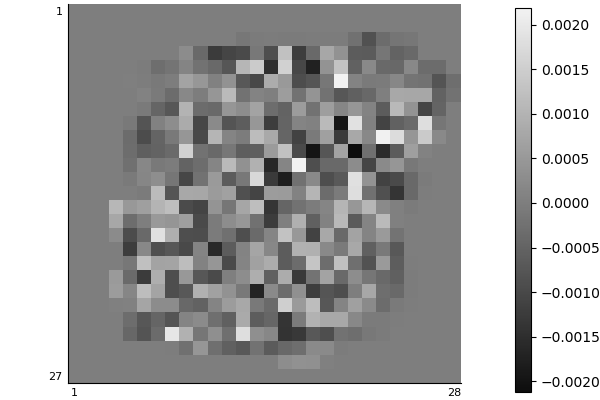

In [37]:
# LS-based classifier
train0_2D=reshape(train0, nx*ny, :);
train1_2D=reshape(train1, nx*ny, :);
A = cat(1,train0_2D',train1_2D');# you complete this using "train0" and "train1" training data
b = [ones(ntrain); -ones(ntrain)]; # this is the "RHS" for LS regression classifier
x_ls = pinv(A)*b# you complete this based on solving the LS problem
jim(reshape(x_ls, nx, ny)) # look at the LS regression coefficients

In [38]:
# assess the classification accuracy based on the LS coefficients 'x_ls'
ls_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_ls) .== 1)
@show ls_correct0 / ntest
ls_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_ls) .== -1)
@show ls_correct1 / ntest

ls_correct0 / ntest = 0.8866666666666667
ls_correct1 / ntest = 0.7722222222222223


0.7722222222222223

In [41]:
# LS works perfectly on (overfit!) training data!
tmp0 = sum(sign.(reshape(train0, nx*ny, :)' * x_ls) .== 1)
@show tmp0 / ntrain
tmp1 = sum(sign.(reshape(train1, nx*ny, :)' * x_ls) .== -1)
@show tmp1 / ntrain

tmp0 / ntrain = 1.0
tmp1 / ntrain = 1.0


1.0

In [43]:
# logistic regression
# cost function: f(x) = sum_i ψ(y_i ⟨x,v_i⟩) + β/2 |x|_2^2
# form V matrix using product of each feature v_i with y_i = ±1
V = cat(2,train0_2D,-1*train1_2D)# you complete this - it should have 100+100 columns
V = V ./ sqrt.(sum(V.^2, 1)) # normalize columns to unit norm
reg = 0.01 # choose regularization parameter β manually for now
size(V)

(756, 200)

In [45]:
# set up for logistic regression
niter = 100
pot = (z) -> log(1 + exp(-z)) # logistic loss function (aka potential function)
dpot = (z) -> -1 / (exp(z) + 1) # its derivative
grad = (x) -> V * dpot.(V' * x) + reg * x # gradient of logistic regression cost
cost = (x) -> sum(pot.(V' * x)) + reg/2 * vecnorm(x)^2 # overall cost function
L = norm(V)^2 / 4 + reg # Lipshitz constant
x0 = zeros(nx*ny); # initialize with 0 regression vector

In [48]:
# Implement Nesterov's FGD (fast gradient descent) for logistic regression cost function
x = copy(x0)
zold = copy(x0)
told = 1
xold = x0;
t=0;
cost_fgd = zeros(niter+1)
cost_fgd[1] = cost(x)
for iter=1:niter
    # some lines needed here
    told = t;
    t = (1+sqrt(1+4*told*told))/2;
    z = x+((told-1)/t)*(x-xold);
    xold = x;
    x = z-1/L*grad(z)# . 

    cost_fgd[iter+1] = cost(x) # compute cost each iteration
end
x_fgd = x; # save final regression classifier weights


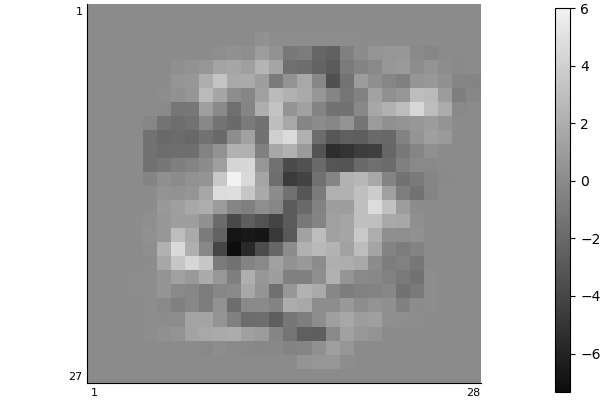

In [57]:
# examine classifier weights
jim(reshape(x_fgd, nx, ny))
#title("Logistic regression weights")


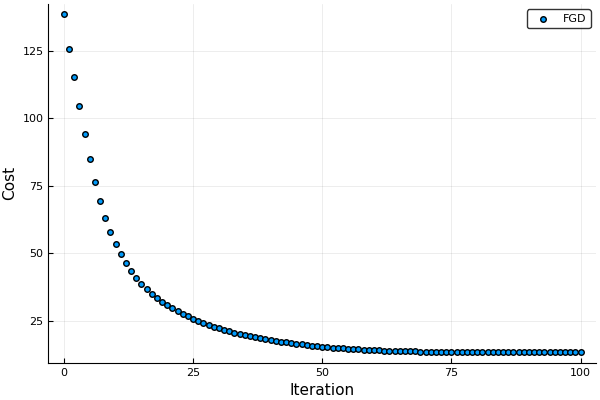

In [51]:
#plot(0:niter, cost_gd, line=(:dots), label="GD")
plot(0:niter, cost_fgd, line=(:dots), label="FGD")
xlabel!("Iteration")
ylabel!("Cost")

In [52]:
# logistic regression based classification
log_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_fgd) .== 1)
@show log_correct0 / ntest
log_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_fgd) .== -1)
@show log_correct1 / ntest

log_correct0 / ntest = 0.9577777777777777
log_correct1 / ntest = 0.89


0.89